In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [4]:
meta.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [73]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [78]:
# Hashing article ids to prevent duplicates between user_id and click_article_id
article_ids = click_df.click_article_id.unique()
article_hashs = pd.util.hash_array(article_ids)

index_to_hash = dict(zip(article_ids, article_hashs))
hash_to_index = dict(zip(article_hashs, article_ids))

len(hash_to_index)

46033

In [81]:
click_df['article_id'] = click_df['click_article_id'].apply(lambda x: index_to_hash[x])
click_df.drop(columns='click_article_id', inplace=True)
click_df.head()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050


In [85]:
click_df = click_df.astype('int')
click_df.describe()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00,-2.371863e+17
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00,5.202839e+18
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-9.223084e+18
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,-4.599056e+18
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,-6.124136e+17
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,4.322660e+18
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,9.222993e+18


In [87]:
tmp = click_df.copy()
tmp['timestamp'] = pd.to_datetime(tmp['click_timestamp'])
tmp.head()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,timestamp
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,-7155129913739455681,1970-01-01 00:25:06.826828020
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682,1970-01-01 00:25:06.826858020
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602,1970-01-01 00:25:06.827017951
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792,1970-01-01 00:25:06.827047951
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050,1970-01-01 00:25:06.827090575


In [ ]:
users = click_df.groupby('user_id').agg(session_count=('session_id', 'nunique'), )

In [72]:
article_hm = {}
for idx in click_df.click_article_id.unique():
        click

In [12]:
cf_matrix = click_df[['user_id','click_article_id','click_timestamp']].groupby(['user_id','click_article_id']).count().reset_index()
cf_matrix

,user_id,click_article_id,click_timestamp
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [14]:
cf_matrix['click_timestamp'].value_counts()

1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
13          6
12          3
33          3
16          2
17          1
30          1
31          1
Name: click_timestamp, dtype: int64

In [38]:
clicks_per_user = cf_matrix[['user_id', 'click_timestamp']].groupby('user_id').count().reset_index()
clicks_per_user.rename(columns={'click_timestamp': 'num_clicks'}, inplace=True)
clicks_per_user = clicks_per_user.sort_values(by='num_clicks', ascending=False)
clicks_per_user.head(30)

,user_id,num_clicks
5890,5890,1048
73574,73574,924
80350,80350,760
15275,15275,712
15867,15867,691
4568,4568,518
2151,2151,513
34541,34541,496
12897,12897,482
4966,4966,441


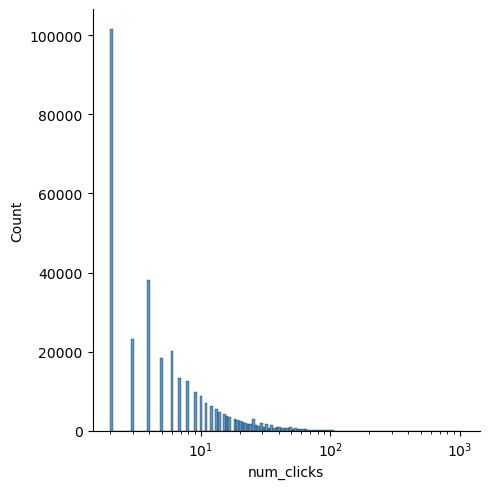

In [62]:
_tmp = clicks_per_user.groupby(['num_clicks']).count().reset_index()
sns.displot(data = clicks_per_user, x='num_clicks', log_scale=True)
plt.show()